<h2> Installing & Importing Necessary Libraries (To be run only after running FineTuning Notebook)</h2>

In [ ]:
%pip install nltk rouge_score gensim pytorch_pretrained_bert bert-score moverscore scipy

In [1]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /teamspace/studios/this_studio/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /teamspace/studios/this_studio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [1]:
import torch
from nltk.translate.bleu_score import corpus_bleu
from moverscore_v2 import word_mover_score
from bert_score import score as bert_score
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, TrainingArguments, GenerationConfig
from peft import LoraConfig, get_peft_model, PeftConfig, PeftModel, prepare_model_for_kbit_training
from trl import SFTTrainer
import warnings
warnings.filterwarnings("ignore")

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


<h2> Loading Original & PEFT Model </h2>

In [2]:
# Loading original model
model_name = "ybelkada/falcon-7b-sharded-bf16"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.float16,
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
)

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

In [3]:
# Loading PEFT model
PEFT_MODEL = "/teamspace/studios/this_studio/falcon-7b-sharded-bf16-finetuned-treccast"

config = PeftConfig.from_pretrained(PEFT_MODEL)
peft_base_model = AutoModelForCausalLM.from_pretrained(
    config.base_model_name_or_path,
    return_dict=True,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
)

peft_model = PeftModel.from_pretrained(peft_base_model, PEFT_MODEL)

peft_tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)
peft_tokenizer.pad_token = peft_tokenizer.eos_token

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

<h2> PEFT Inference Model </h2>

In [6]:
def generate_answer(query):
    system_prompt = """Answer the following question truthfully.
If you don't know the answer, respond 'Sorry, I don't know the answer to this question.'.
If the question is too complex, respond 'Kindly, consult the author.'."""

    user_prompt = f"<HUMAN>: {query}\n<ASSISTANT>:"

    final_prompt = f"{system_prompt}\n\n{user_prompt}"

    device = "cuda:0"
    dashline = "-" * 50

    # Tokenize and generate the response with the original model
    encoding = tokenizer(final_prompt, return_tensors="pt").to(device)
    outputs = model.generate(input_ids=encoding.input_ids, 
                             max_length=256,  # Adjust max length as per your model's maximum generation capacity
                             pad_token_id=tokenizer.eos_token_id, 
                             eos_token_id=tokenizer.eos_token_id, 
                             attention_mask=encoding.attention_mask, 
                             temperature=0.6, 
                             top_p=0.7, 
                             repetition_penalty=1.2, 
                             num_return_sequences=1)
    text_output = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Extract and format original model response
    formatted_output = extract_response(text_output, query)

    # Print original model response
    print(dashline)
    print(f'ORIGINAL MODEL RESPONSE:\n{formatted_output}')
    print(dashline)

    # Tokenize and generate the response with the PEFT model
    peft_encoding = peft_tokenizer(final_prompt, return_tensors="pt").to(device)
    peft_outputs = peft_model.generate(input_ids=peft_encoding.input_ids, 
                                       max_length=256,  # Adjust max length as per your model's maximum generation capacity
                                       pad_token_id=peft_tokenizer.eos_token_id, 
                                       eos_token_id=peft_tokenizer.eos_token_id, 
                                       attention_mask=peft_encoding.attention_mask, 
                                       temperature=0.6, 
                                       top_p=0.7, 
                                       repetition_penalty=1.2, 
                                       num_return_sequences=1)
    peft_text_output = peft_tokenizer.decode(peft_outputs[0], skip_special_tokens=True)

    # Extract and format PEFT model response
    peft_formatted_output = extract_response(peft_text_output, query)

    # Print PEFT model response
    print(f'PEFT MODEL RESPONSE:\n{peft_formatted_output}')
    print(dashline)

def extract_response(text_output, query):
    assistant_tag = "<ASSISTANT>:"
    if assistant_tag in text_output:
        response_part = text_output.split(assistant_tag)[1].strip()
        if response_part:
            # Check for unwanted <HUMAN> tag in the response and remove it
            response_part = response_part.split("<HUMAN>:")[0].strip()
            return f"<HUMAN>: {query}\n<ASSISTANT>: {response_part}"

    # Default to predefined fallback responses if no valid response is found
    if "Sorry, I don't know the answer to this question." in text_output:
        return f"<HUMAN>: {query}\n<ASSISTANT>: Sorry, I don't know the answer to this question."
    elif "Kindly, consult the author." in text_output:
        return f"<HUMAN>: {query}\n<ASSISTANT>: Kindly, consult the author."

    # If the response is completely missing or unidentifiable
    return f"<HUMAN>: {query}\n<ASSISTANT>: Sorry, I don't know the answer to this question."

# Example usage
generate_answer("What is COP26?")
generate_answer("How would climate change affect countries?")
generate_answer("How do you mnake your own Deodorant?")



--------------------------------------------------
ORIGINAL MODEL RESPONSE:
<HUMAN>: What is COP26?
<ASSISTANT>: COP26 is the 26th Conference of the Parties to the United Nations Framework Convention on Climate Change.
--------------------------------------------------
PEFT MODEL RESPONSE:
<HUMAN>: What is COP26?
<ASSISTANT>: The name of the COP event series is "COP26". The twenty-sixth conference of the parties (to the United Nations Convention on Climate Change) will be held at the Scottish Event Campus in Glasgow, Scotland, from October 31 to November 12, 2021. It is a governmental summit about climate change and its mitigation and adaptation measures. Approximately 195 countries are expected to participate as delegates. The term "COP" is often misused as a synonym for "climate change conference", although the Conference of the Parties is used to refer all the way back to the 1992 UNFCCC Kyoto Protocol! A conference is much bigger than a meeting. The proper noun "conference of the p

<h2> Calculating BLEU (its tokenization) & ROUGE Score for first 20 Dialogues in our Dataset  </h2>

In [9]:
import json
import nltk
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu
from datasets import load_metric

# Ensure NLTK packages are downloaded
nltk.download('punkt')

# Function to calculate BLEU score
def calculate_bleu(predictions, references):
    # Tokenize the predictions and references
    tokenized_predictions = [nltk.word_tokenize(pred) for pred in predictions]
    tokenized_references = [[nltk.word_tokenize(ref)] for ref in references]

    # Print tokenization output for verification
    print("Tokenized Predictions:", tokenized_predictions)
    print("Tokenized References:", tokenized_references)

    # Use NLTK's BLEU implementation
    bleu_score_value = corpus_bleu(tokenized_references, tokenized_predictions)
    return bleu_score_value

# Function to calculate ROUGE score
def calculate_rouge(predictions, references):
    rouge_metric = load_metric("rouge")
    rouge_scores = rouge_metric.compute(predictions=predictions, references=references)
    return rouge_scores

# Function to generate answer and evaluate with BLEU and ROUGE scores
def generate_answer(query, reference):
    system_prompt = """Answer the following question truthfully.
If you don't know the answer, respond 'Sorry, I don't know the answer to this question.'.
If the question is too complex, respond 'Kindly, consult the author.'."""

    user_prompt = f"<HUMAN>: {query}\n<ASSISTANT>:"

    final_prompt = f"{system_prompt}\n\n{user_prompt}"

    device = "cuda:0"
    dashline = "-" * 50

    # Tokenize and generate the response with the original model
    encoding = tokenizer(final_prompt, return_tensors="pt").to(device)
    outputs = model.generate(input_ids=encoding.input_ids,
                             max_length=256,  # Adjust max length as per your model's maximum generation capacity
                             pad_token_id=tokenizer.eos_token_id,
                             eos_token_id=tokenizer.eos_token_id,
                             attention_mask=encoding.attention_mask,
                             temperature=0.6,
                             top_p=0.7,
                             repetition_penalty=1.2,
                             num_return_sequences=1)
    text_output = tokenizer.decode(outputs[0], skip_special_tokens=True)
    original_formatted_output = extract_response(text_output, query)

    # Print original model question and response
    print(dashline)
    print(f'QUESTION:\n{query}')
    print(f'ORIGINAL MODEL RESPONSE:\n{original_formatted_output}')

    # Calculate BLEU score for original model
    original_bleu_score = calculate_bleu([original_formatted_output], [reference])
    print(f'ORIGINAL MODEL BLEU Score: {original_bleu_score}')

    # Calculate ROUGE scores for original model
    original_rouge_scores = calculate_rouge([original_formatted_output], [reference])
    print(f'ORIGINAL MODEL ROUGE Scores: {original_rouge_scores}')

    print(dashline)

    # Tokenize and generate the response with the PEFT model
    peft_encoding = peft_tokenizer(final_prompt, return_tensors="pt").to(device)
    peft_outputs = peft_model.generate(input_ids=peft_encoding.input_ids,
                                       max_length=256,  # Adjust max length as per your model's maximum generation capacity
                                       pad_token_id=peft_tokenizer.eos_token_id,
                                       eos_token_id=peft_tokenizer.eos_token_id,
                                       attention_mask=peft_encoding.attention_mask,
                                       temperature=0.6,
                                       top_p=0.7,
                                       repetition_penalty=1.2,
                                       num_return_sequences=1)
    peft_text_output = peft_tokenizer.decode(peft_outputs[0], skip_special_tokens=True)
    peft_formatted_output = extract_response(peft_text_output, query)

    # Print PEFT model response
    print(f'PEFT MODEL RESPONSE:\n{peft_formatted_output}')

    # Calculate BLEU score for PEFT model
    peft_bleu_score = calculate_bleu([peft_formatted_output], [reference])
    print(f'PEFT MODEL BLEU Score: {peft_bleu_score}')

    # Calculate ROUGE scores for PEFT model
    peft_rouge_scores = calculate_rouge([peft_formatted_output], [reference])
    print(f'PEFT MODEL ROUGE Scores: {peft_rouge_scores}')

    print(dashline)

def extract_response(text_output, query):
    parts = text_output.split("<HUMAN>:")[1:]  # Skip the first empty part
    for part in parts:
        if part.startswith(f" {query}"):
            assistant_idx = part.find("<ASSISTANT>:")
            assistant_response = part[assistant_idx + len("<ASSISTANT>:"):].strip()
            return assistant_response
    return "[No response available]"

# Load your dataset
with open("/teamspace/studios/this_studio/formatted_dialogue.json") as f:
    data = json.load(f)

# Restrict to the first 20 dialogues
data = data[:20]

# Evaluate on each query and reference
for item in data:
    dialogue = item["dialogue"]
    human_part = dialogue.split("<ASSISTANT>:")[0].strip()
    assistant_part = dialogue.split("<ASSISTANT>:")[1].strip()
    query = human_part.split("<HUMAN>:")[1].strip()
    reference = assistant_part.strip()
    generate_answer(query, reference)

[nltk_data] Downloading package punkt to
[nltk_data]     /teamspace/studios/this_studio/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


--------------------------------------------------
QUESTION:
I remember Glasgow hosting COP26 last year, but unfortunately I was out of the loop. What was it about?
ORIGINAL MODEL RESPONSE:
It was a conference on climate change.
Tokenized Predictions: [['It', 'was', 'a', 'conference', 'on', 'climate', 'change', '.']]
Tokenized References: [[['The', 'COP26', 'event', 'is', 'a', 'global', 'united', 'Nations', 'summit', 'about', 'climate', 'change', 'and', 'how', 'countries', 'are', 'planning', 'to', 'tackle', 'it', '.', 'The', 'term', '“', 'climate', 'change', '”', 'is', 'often', 'used', 'as', 'if', 'it', 'means', 'the', 'same', 'thing', 'as', 'the', 'term', '“', 'global', 'warming', '”', '.', 'The', 'National', 'Academy', 'of', 'Sciences', 'says', '“', 'climate', 'change', '”', 'is', 'growing', 'in', 'favor', 'of', '“', 'global', 'warming', '”', 'because', 'it', 'helps', 'convey', 'that', 'there', 'are', 'other', 'changes', 'in', 'addition', 'to', 'rising', 'temperatures', '.', 'In', 'f

<h2>Calculating Average BLEU & ROUGE Score over the entire Dataset</h2>

[nltk_data] Downloading package punkt to
[nltk_data]     /teamspace/studios/this_studio/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Average BLEU score for Original Model: 0.0004989965366655631
Average BLEU score for PEFT Model: 0.07361871207919557
Average ROUGE score for Original Model: 0.06148177544238058
Average ROUGE score for PEFT Model: 0.19468502717373629


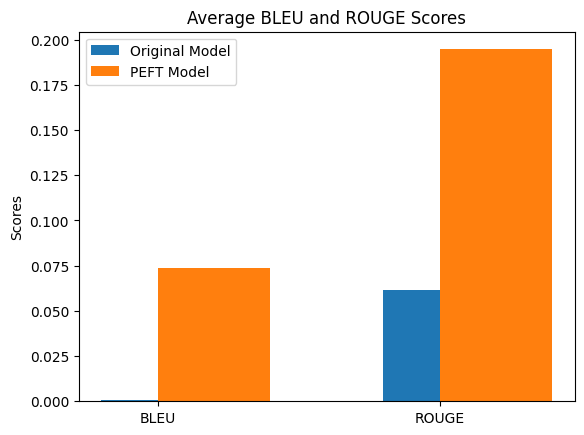

In [4]:
import json
import nltk
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu
from datasets import load_metric
import matplotlib.pyplot as plt

# Ensure NLTK packages are downloaded
nltk.download('punkt')

# Function to calculate BLEU score
def calculate_bleu(predictions, references):
    # Tokenize the predictions and references
    tokenized_predictions = [nltk.word_tokenize(pred) for pred in predictions]
    tokenized_references = [[nltk.word_tokenize(ref)] for ref in references]

    # Use NLTK's BLEU implementation
    bleu_score_value = corpus_bleu(tokenized_references, tokenized_predictions)
    return bleu_score_value

# Function to calculate ROUGE score
def calculate_rouge(predictions, references):
    rouge_metric = load_metric("rouge")
    rouge_scores = rouge_metric.compute(predictions=predictions, references=references)
    return rouge_scores

# Function to generate answer and evaluate with BLEU and ROUGE scores
def generate_answer(query, reference):
    system_prompt = """Answer the following question truthfully.
If you don't know the answer, respond 'Sorry, I don't know the answer to this question.'.
If the question is too complex, respond 'Kindly, consult the author.'."""

    user_prompt = f"<HUMAN>: {query}\n<ASSISTANT>:"

    final_prompt = f"{system_prompt}\n\n{user_prompt}"

    device = "cuda:0"
    dashline = "-" * 50

    # Tokenize and generate the response with the original model
    encoding = tokenizer(final_prompt, return_tensors="pt").to(device)
    outputs = model.generate(input_ids=encoding.input_ids,
                             max_length=256,  # Adjust max length as per your model's maximum generation capacity
                             pad_token_id=tokenizer.eos_token_id,
                             eos_token_id=tokenizer.eos_token_id,
                             attention_mask=encoding.attention_mask,
                             temperature=0.6,
                             top_p=0.7,
                             repetition_penalty=1.2,
                             num_return_sequences=1)
    text_output = tokenizer.decode(outputs[0], skip_special_tokens=True)
    original_formatted_output = extract_response(text_output, query)

    # Calculate BLEU score for original model
    original_bleu_score = calculate_bleu([original_formatted_output], [reference])

    # Calculate ROUGE scores for original model
    original_rouge_scores = calculate_rouge([original_formatted_output], [reference])

    # Tokenize and generate the response with the PEFT model
    peft_encoding = peft_tokenizer(final_prompt, return_tensors="pt").to(device)
    peft_outputs = peft_model.generate(input_ids=peft_encoding.input_ids,
                                       max_length=256,  # Adjust max length as per your model's maximum generation capacity
                                       pad_token_id=peft_tokenizer.eos_token_id,
                                       eos_token_id=peft_tokenizer.eos_token_id,
                                       attention_mask=peft_encoding.attention_mask,
                                       temperature=0.6,
                                       top_p=0.7,
                                       repetition_penalty=1.2,
                                       num_return_sequences=1)
    peft_text_output = peft_tokenizer.decode(peft_outputs[0], skip_special_tokens=True)
    peft_formatted_output = extract_response(peft_text_output, query)

    # Calculate BLEU score for PEFT model
    peft_bleu_score = calculate_bleu([peft_formatted_output], [reference])

    # Calculate ROUGE scores for PEFT model
    peft_rouge_scores = calculate_rouge([peft_formatted_output], [reference])

    return original_bleu_score, peft_bleu_score, original_rouge_scores, peft_rouge_scores

def extract_response(text_output, query):
    parts = text_output.split("<HUMAN>:")[1:]  # Skip the first empty part
    for part in parts:
        if part.startswith(f" {query}"):
            assistant_idx = part.find("<ASSISTANT>:")
            assistant_response = part[assistant_idx + len("<ASSISTANT>:"):].strip()
            return assistant_response
    return "[No response available]"

# Load your dataset
with open("/teamspace/studios/this_studio/formatted_dialogue.json") as f:
    data = json.load(f)


# Initialize lists to store BLEU and ROUGE scores
original_bleu_scores = []
peft_bleu_scores = []
original_rouge_scores_list = []
peft_rouge_scores_list = []

# Evaluate on each query and reference
for item in data:
    dialogue = item["dialogue"]
    human_part = dialogue.split("<ASSISTANT>:")[0].strip()
    assistant_part = dialogue.split("<ASSISTANT>:")[1].strip()
    query = human_part.split("<HUMAN>:")[1].strip()
    reference = assistant_part.strip()
    
    original_bleu, peft_bleu, original_rouge, peft_rouge = generate_answer(query, reference)
    
    # Append the scores to the lists
    original_bleu_scores.append(original_bleu)
    peft_bleu_scores.append(peft_bleu)
    original_rouge_scores_list.append(original_rouge['rougeL'].mid.fmeasure)
    peft_rouge_scores_list.append(peft_rouge['rougeL'].mid.fmeasure)

# Calculate average scores
avg_original_bleu = sum(original_bleu_scores) / len(original_bleu_scores) if original_bleu_scores else 0
avg_peft_bleu = sum(peft_bleu_scores) / len(peft_bleu_scores) if peft_bleu_scores else 0
avg_original_rouge = sum(original_rouge_scores_list) / len(original_rouge_scores_list) if original_rouge_scores_list else 0
avg_peft_rouge = sum(peft_rouge_scores_list) / len(peft_rouge_scores_list) if peft_rouge_scores_list else 0

# Print average scores
print(f"Average BLEU score for Original Model: {avg_original_bleu}")
print(f"Average BLEU score for PEFT Model: {avg_peft_bleu}")
print(f"Average ROUGE score for Original Model: {avg_original_rouge}")
print(f"Average ROUGE score for PEFT Model: {avg_peft_rouge}")

# Plot the average scores
labels = ['BLEU', 'ROUGE']
original_scores = [avg_original_bleu, avg_original_rouge]
peft_scores = [avg_peft_bleu, avg_peft_rouge]

x = range(len(labels))

fig, ax = plt.subplots()
ax.bar(x, original_scores, width=0.4, label='Original Model', align='center')
ax.bar(x, peft_scores, width=0.4, label='PEFT Model', align='edge')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel('Scores')
ax.set_title('Average BLEU and ROUGE Scores')
ax.legend()

plt.show()

<h2>Calculating BERTScore & MoverScore for first 20 dialogues in our Dataset</h2>

In [5]:
import json
import nltk
import torch
import numpy as np
from bert_score import score as bert_score
from transformers import AutoTokenizer, AutoModelForCausalLM
from gensim.models import KeyedVectors
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from scipy.spatial.distance import euclidean
from scipy.optimize import linear_sum_assignment

# Ensure NLTK packages are downloaded
nltk.download('punkt')
nltk.download('stopwords')

# Function to calculate BERTScore
def calculate_bertscore(predictions, references):
    P, R, F1 = bert_score(predictions, references, lang="en", rescale_with_baseline=True)
    return {"P": P.mean().item(), "R": R.mean().item(), "F1": F1.mean().item()}

# Function to preprocess and tokenize text
def preprocess_text(text):
    # Tokenize text and remove stopwords
    tokens = nltk.word_tokenize(text.lower())
    tokens = [token for token in tokens if token.isalnum()]
    stop_words = set(nltk.corpus.stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    return tokens

# Function to calculate MoverScore between two sentences
def calculate_moverscore(sentence1, sentence2, word2vec_model):
    tokens1 = preprocess_text(sentence1)
    tokens2 = preprocess_text(sentence2)

    # Get embeddings for each token in both sentences
    embeddings1 = np.array([word2vec_model[token] for token in tokens1 if token in word2vec_model])
    embeddings2 = np.array([word2vec_model[token] for token in tokens2 if token in word2vec_model])

    # Compute distance matrix between embeddings
    distance_matrix = np.zeros((len(embeddings1), len(embeddings2)))
    for i, emb1 in enumerate(embeddings1):
        for j, emb2 in enumerate(embeddings2):
            distance_matrix[i, j] = euclidean(emb1, emb2)

    # Compute optimal transport plan using linear sum assignment
    row_ind, col_ind = linear_sum_assignment(distance_matrix)

    # Calculate MoverScore
    total_distance = distance_matrix[row_ind, col_ind].sum()
    moverscore = 1 / (1 + total_distance)  # Normalize to get MoverScore between 0 and 1

    return moverscore

# Function to generate answer and evaluate with BERTScore and MoverScore
def generate_answer(query, reference):
    system_prompt = """Answer the following question truthfully.
    If you don't know the answer, respond 'Sorry, I don't know the answer to this question.'.
    If the question is too complex, respond 'Kindly, consult the author.'."""

    user_prompt = f"<HUMAN>: {query}\n<ASSISTANT>:"

    final_prompt = f"{system_prompt}\n\n{user_prompt}"

    device = "cuda" if torch.cuda.is_available() else "cpu"
    dashline = "-" * 50

    encoding = tokenizer(final_prompt, return_tensors="pt").to(device)
    outputs = model.generate(input_ids=encoding.input_ids,
                             max_length=256,
                             pad_token_id=tokenizer.eos_token_id,
                             eos_token_id=tokenizer.eos_token_id,
                             attention_mask=encoding.attention_mask,
                             temperature=0.6,
                             top_p=0.7,
                             repetition_penalty=1.2,
                             num_return_sequences=1)
    text_output = tokenizer.decode(outputs[0], skip_special_tokens=True)
    original_formatted_output = extract_response(text_output, query)

    # Print original model question and response
    print(dashline)
    print(f'QUESTION:\n{query}')
    print(f'ORIGINAL MODEL RESPONSE:\n{original_formatted_output}')

    # Calculate BERTScore for original model
    original_bertscore = calculate_bertscore([original_formatted_output], [reference])
    print(f'ORIGINAL MODEL BERTScore: P={original_bertscore["P"]}, R={original_bertscore["R"]}, F1={original_bertscore["F1"]}')

    # Calculate MoverScore for original model
    word2vec_model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)
    original_moverscore = calculate_moverscore(original_formatted_output, reference, word2vec_model)
    print(f'ORIGINAL MODEL MoverScore: {original_moverscore}')

    print(dashline)

    peft_encoding = peft_tokenizer(final_prompt, return_tensors="pt").to(device)
    peft_outputs = peft_model.generate(input_ids=peft_encoding.input_ids,
                                        max_length=256,
                                        pad_token_id=peft_tokenizer.eos_token_id,
                                        eos_token_id=peft_tokenizer.eos_token_id,
                                        attention_mask=peft_encoding.attention_mask,
                                        temperature=0.6,
                                        top_p=0.7,
                                        repetition_penalty=1.2,
                                        num_return_sequences=1)
    peft_text_output = peft_tokenizer.decode(peft_outputs[0], skip_special_tokens=True)
    peft_formatted_output = extract_response(peft_text_output, query)

    # Print PEFT model response
    print(f'PEFT MODEL RESPONSE:\n{peft_formatted_output}')

    # Calculate BERTScore for PEFT model
    peft_bertscore = calculate_bertscore([peft_formatted_output], [reference])
    print(f'PEFT MODEL BERTScore: P={peft_bertscore["P"]}, R={peft_bertscore["R"]}, F1={peft_bertscore["F1"]}')

    # Calculate MoverScore for PEFT model
    peft_moverscore = calculate_moverscore(peft_formatted_output, reference, word2vec_model)
    print(f'PEFT MODEL MoverScore: {peft_moverscore}')

    print(dashline)


def extract_response(text_output, query):
    parts = text_output.split("<HUMAN>:")[1:]  # Skip the first empty part
    for part in parts:
        if part.startswith(f" {query}"):
            assistant_idx = part.find("<ASSISTANT>:")
            assistant_response = part[assistant_idx + len("<ASSISTANT>:"):].strip()
            return assistant_response
    return "[No response available]"


# Load your dataset
with open("/teamspace/studios/this_studio/formatted_dialogue.json") as f:
    data = json.load(f)

# Restrict to the first 20 dialogues
data = data[:20]

# Evaluate on each query and reference
for item in data:
    dialogue = item["dialogue"]
    human_part = dialogue.split("<ASSISTANT>:")[0].strip()
    assistant_part = dialogue.split("<ASSISTANT>:")[1].strip()
    query = human_part.split("<HUMAN>:")[1].strip()
    reference = assistant_part.strip()
    generate_answer(query, reference)


[nltk_data] Downloading package punkt to
[nltk_data]     /teamspace/studios/this_studio/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /teamspace/studios/this_studio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


--------------------------------------------------
QUESTION:
I remember Glasgow hosting COP26 last year, but unfortunately I was out of the loop. What was it about?
ORIGINAL MODEL RESPONSE:
It was a conference on climate change.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ORIGINAL MODEL BERTScore: P=0.5039013028144836, R=-0.07908180356025696, F1=0.19719505310058594
ORIGINAL MODEL MoverScore: 0.2547206289503811
--------------------------------------------------
PEFT MODEL RESPONSE:
The COP26 event is a global united Nations summit about climate change and how countries are planning to tackle it. Name a conference or gathering you’d like to attend and we can find a way to make it happen for you with our bespoke coaching program. Even if you attended COP26 last year, this is relevant; as Climate Change is constantly evolving, with new data emerging almost every day. They made strides towards carbon neutrality and there is still lots more to do. It is a long-term journey which will continue to challenge many leaders moving forward. Sometimes the pressure from Climate Change could impact their ability to carry out business duties. These days they may be suffering from some kind of mental health issue due to the burden they are under. We would investigate thi

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


PEFT MODEL BERTScore: P=0.09218805283308029, R=0.17239251732826233, F1=0.13338503241539001
PEFT MODEL MoverScore: 0.009526759961918662
--------------------------------------------------
--------------------------------------------------
QUESTION:
Interesting. What are the effects of these changes?
ORIGINAL MODEL RESPONSE:
The effects of these changes are as follows:


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ORIGINAL MODEL BERTScore: P=0.04127012938261032, R=-0.2038775235414505, F1=-0.0826437845826149
ORIGINAL MODEL MoverScore: 0.12407331142220603
--------------------------------------------------
PEFT MODEL RESPONSE:
The first one is about increasing your website’s visibility. You see that when you search in Google with an address already specified, the entire page and all its results will be shown in the first result block, instead of just the link title, description and URL. This makes the organic result look more complete and attractive. Do you want to make your site visible on Internet? Then increase your SEO! By doing so, you also force users who browse the web by means of search engines to pay attention to your address rather than those of others. To raise awareness for your brand, it is better if the search engine shows a lot of information about it in the search result list. In addition, Google now displays more details of websites in the search results. With expanded presentation

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


PEFT MODEL BERTScore: P=-0.11426553130149841, R=-0.16954609751701355, F1=-0.1402112990617752
PEFT MODEL MoverScore: 0.011144180825880071
--------------------------------------------------
--------------------------------------------------
QUESTION:
That’s rather vague. Can you be more specific?
ORIGINAL MODEL RESPONSE:
I’m sorry, I don’t know the answer to this question.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ORIGINAL MODEL BERTScore: P=-0.07609247416257858, R=-0.2149183303117752, F1=-0.1446523219347
ORIGINAL MODEL MoverScore: 0.08746127293679756
--------------------------------------------------
PEFT MODEL RESPONSE:
Answer one of the most common stock market questions: how do I calculate my ROE? And expand upon it; for example, by describing the components of your diet and why you chose them. Show genuine interest in their hobbies and passions and support them in pursuing them. No teenager wants to feel like they’re locked in a cage. They need to feel free to explore the world and find out about new things. Encourage original thinking. Teach them something new every day. Inspire them to discover their unique strengths and talents. The greatest athlete, the smartest student, the highest achieving person in academics are all great accolades but won’t ever mean anything if their soul is torn apart due to bullying inflicted because they’re different from the rest. Support them in finding their

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


PEFT MODEL BERTScore: P=-0.14407242834568024, R=-0.14993244409561157, F1=-0.14514073729515076
PEFT MODEL MoverScore: 0.003944164503454565
--------------------------------------------------
--------------------------------------------------
QUESTION:
Woah. They’re not all bad, right?
ORIGINAL MODEL RESPONSE:
No, they’re not.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ORIGINAL MODEL BERTScore: P=-0.00328809698112309, R=-0.18977594375610352, F1=-0.09654918313026428
ORIGINAL MODEL MoverScore: 1.0
--------------------------------------------------
PEFT MODEL RESPONSE:
A biased algorithm is one which systematically makes errors or omissions in handling a group of data; however, algorithms are not inherently flawed. Some algorithms, such as Newton’s method, are very robust and reliable. In addition, an algorithm does not determine whether a mistake is intentional or accidental. An algorithm that has gone wrong due to an error or flaw can still be re-executed and correct the error. The term “algorithm crash” suggests that an algorithm falls apart and loses its ability to perform inference. This kind of failure would imply that the algorithm was fundamentaly broken and cannot be reused. Modern machine learning systems based on deep neural networks are highly susceptible to data noise, model initialization problems, and other easy-to-fall-apart issues. Howe

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


PEFT MODEL BERTScore: P=-0.12047877907752991, R=-0.09524205327033997, F1=-0.1060926765203476
PEFT MODEL MoverScore: 0.006696587519534818
--------------------------------------------------
--------------------------------------------------
QUESTION:
I remember Glasgow hosting COP26 last year, but unfortunately I was out of the loop. What was it about?
ORIGINAL MODEL RESPONSE:
It was a conference on climate change.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ORIGINAL MODEL BERTScore: P=0.5039013028144836, R=-0.07908180356025696, F1=0.19719505310058594
ORIGINAL MODEL MoverScore: 0.2547206289503811
--------------------------------------------------
PEFT MODEL RESPONSE:
The COP26 event is a global united Nations summit about climate change and how countries are planning to tackle it. Name a conference or gathering you’d like to attend and we can find a way to make it happen for you with our bespoke coaching program. Even if you attended COP26 last year, this is relevant; as Climate Change is constantly evolving, with new data emerging almost every day. They made strides towards carbon neutrality and there is still lots more to do. It is a long-term journey which will continue to challenge many leaders moving forward. Sometimes the pressure from Climate Change could impact their ability to carry out business duties. These days they may be suffering from some kind of mental health issue due to the burden they are under. We would investigate thi

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


PEFT MODEL BERTScore: P=0.09218805283308029, R=0.17239251732826233, F1=0.13338503241539001
PEFT MODEL MoverScore: 0.009526759961918662
--------------------------------------------------
--------------------------------------------------
QUESTION:
Interesting. What are the effects of these changes?
ORIGINAL MODEL RESPONSE:
The effects of these changes are as follows:


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ORIGINAL MODEL BERTScore: P=0.04127012938261032, R=-0.2038775235414505, F1=-0.0826437845826149
ORIGINAL MODEL MoverScore: 0.12407331142220603
--------------------------------------------------
PEFT MODEL RESPONSE:
The first one is about increasing your website’s visibility. You see that when you search in Google with an address already specified, the entire page and all its results will be shown in the first result block, instead of just the link title, description and URL. This makes the organic result look more complete and attractive. Do you want to make your site visible on Internet? Then increase your SEO! By doing so, you also force users who browse the web by means of search engines to pay attention to your address rather than those of others. To raise awareness for your brand, it is better if the search engine shows a lot of information about it in the search result list. In addition, Google now displays more details of websites in the search results. With expanded presentation

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


PEFT MODEL BERTScore: P=-0.11426553130149841, R=-0.16954609751701355, F1=-0.1402112990617752
PEFT MODEL MoverScore: 0.011144180825880071
--------------------------------------------------
--------------------------------------------------
QUESTION:
That’s interesting. Tell me more.
ORIGINAL MODEL RESPONSE:
I’m sorry, I don’t know the answer to this question.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ORIGINAL MODEL BERTScore: P=-0.05405178666114807, R=-0.18943707644939423, F1=-0.12087568640708923
ORIGINAL MODEL MoverScore: 0.08476297844086428
--------------------------------------------------
PEFT MODEL RESPONSE:
A man named Phil McGraw was travelling through airports, noticing how nervous and anxious people were; he noted that a typical experience includes loud noises, crowded spaces, and general chaos. In those moments of panic, people tend to act without thought or reason. They have lost the ability to think clearly and rationally. This book spurred seminars, radio shows, and TV programs devoted to self-help for everyday problems. The defining feature of self-help is its attempt to create positive change in an individual's life by providing information and techniques. This kind of writing has become so common and widespread that it has spawned entire industries: bookstore shelves are packed with titles on the topic, and websites offer daily doses of self-help via e-mail subscrip

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


PEFT MODEL BERTScore: P=-0.05074847862124443, R=-0.09036136418581009, F1=-0.06889695674180984
PEFT MODEL MoverScore: 0.003836784148338527
--------------------------------------------------
--------------------------------------------------
QUESTION:
Okay, but how does it affect developing countries?
ORIGINAL MODEL RESPONSE:
It doesn't.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ORIGINAL MODEL BERTScore: P=0.07760581374168396, R=-0.19673512876033783, F1=-0.061703044921159744
ORIGINAL MODEL MoverScore: 1.0
--------------------------------------------------
PEFT MODEL RESPONSE:
Developing countries are those that are economically underdeveloped and who have a low level of technological advancement. They are the least able to adapt to climate change. Climate change causes them: Economic losses on account of reduced yields on agricultural lands due to changing patterns of precipitation; Losses in fisheries due to changes in temperature, acidity, and other alterations in the quality of water; The migration of people living in developing nations in search of better climatic conditions; Environmental degradation in the form of loss of vegetation leading to soil erosion; All these impacts of climate change cause about 400,000 deaths per year on average on account of hunger and diseases spread by insects. In addition, climate change also leads to political instability 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


PEFT MODEL BERTScore: P=0.23850925266742706, R=0.38139551877975464, F1=0.31010517477989197
PEFT MODEL MoverScore: 0.01589650245594911
--------------------------------------------------
--------------------------------------------------
QUESTION:
How are developed countries helping with that?
ORIGINAL MODEL RESPONSE:
Well, they're helping by providing financial aid to developing countries.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ORIGINAL MODEL BERTScore: P=0.36952444911003113, R=0.014793814159929752, F1=0.18733759224414825
ORIGINAL MODEL MoverScore: 0.09163850408865673
--------------------------------------------------
PEFT MODEL RESPONSE:
Well, according to the Paris Agreement, every two years, developed countries are expected to communicate the projected levels of public climate finance they provide to developing countries to mitigate and adapt to climate change. Some developing countries also contribute to climate finance as well. Already, Brazil’s President Dilma Rousseff said the country is considering contributing, joining other emerging economies like China, which pledged to provide $3.1 billion over three years. The U.S. hasn’t committed to climate finance yet, despite promises to provide diplomatic support to developing nations facing climate migration due to rising seas, according to Nicholas Watts, director of the National Academy of Sciences’ Climate Project. “The United States has historically bee

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


PEFT MODEL BERTScore: P=0.4853793680667877, R=0.919308066368103, F1=0.6944990158081055
PEFT MODEL MoverScore: 1.0
--------------------------------------------------
--------------------------------------------------
QUESTION:
Are they meeting them?
ORIGINAL MODEL RESPONSE:
Yes, they are.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ORIGINAL MODEL BERTScore: P=0.0509922131896019, R=-0.1356794685125351, F1=-0.04243240877985954
ORIGINAL MODEL MoverScore: 0.2706173680658519
--------------------------------------------------
PEFT MODEL RESPONSE:
At the end of their work, the enthusiasts have created a very comprehensive three-book series based on the characters and universes. The books serve as encyclopedias of the franchises, containing information about the worlds and the characters, as well as various facts and trivia. They have also given fans a way to continue the universes in their own imaginations through fiction. Fans who read these books are encouraged to imagine their own continuities in the realms of comics, novels, and games. In addition, these books act as marketing tools by creating interest for more merchandise; if a book does well, it is likely that a movie or comic spin-off will be made. These books represent a financial investment which generates revenue far exceeding the cost of creation. It is ther

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


PEFT MODEL BERTScore: P=-0.11474238336086273, R=-0.04757628217339516, F1=-0.07963307946920395
PEFT MODEL MoverScore: 0.010787925796543738
--------------------------------------------------
--------------------------------------------------
QUESTION:
That’s not too relevant to my question. By the way, is that related to last year’s conference?
ORIGINAL MODEL RESPONSE:
Yes, it is.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ORIGINAL MODEL BERTScore: P=0.08383745700120926, R=-0.24221275746822357, F1=-0.08290724456310272
ORIGINAL MODEL MoverScore: 0.27266322804792675
--------------------------------------------------
PEFT MODEL RESPONSE:
The Paris Agreement is a big international agreement to tackle climate change. Countries are welcome to join negotiations to deepen their commitments to slash greenhouse gas emissions, and at the same time, all nations are expected to align their economies with the goal of limiting projected temperature increases to 2C above pre-industrial levels. The biggest polluters aren’t signing on: U.S. President Donald Trump has vowed to exit the deal as soon as possible. And some key emerging markets like China are not even part of the agreement. Yet, the day Congress was signed into law in December 2015. Some experts say it could be the catalyst for real action from other countries to cut carbon emissions as well. Dr. Richard Moss, associate professor of environmental studies at Ba

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


PEFT MODEL BERTScore: P=0.18171697854995728, R=0.4117096960544586, F1=0.29533734917640686
PEFT MODEL MoverScore: 0.024332017490470752
--------------------------------------------------
--------------------------------------------------
QUESTION:
So what happens at each COP?
ORIGINAL MODEL RESPONSE:
Well, the first thing that happens is that the delegates gather in the plenary hall.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ORIGINAL MODEL BERTScore: P=0.10451550036668777, R=-0.19044165313243866, F1=-0.04571504890918732
ORIGINAL MODEL MoverScore: 0.04489216573427273
--------------------------------------------------
PEFT MODEL RESPONSE:
The United Nations Climate Change Conference are yearly conferences held in the framework of the UNFCCC. Each conference is known as a COP. The objective of these conferences is to assess the second round of Kyoto Protocol emissions reduction commitments made by developed countries and the first set of obligations agreed upon by emerging economies starting with developing countries who are exempt from KP obligations. These conferences also serve as the basis for the fifth assessment report published by the Intergovernmental Panel on Climate Change. There have been a total of twenty-two COPs since the treaty came into force in 1994. Because climate change is a global problem that requires collective action by all nations, international consensus is considered essential for a

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


PEFT MODEL BERTScore: P=0.17863087356090546, R=0.31292614340782166, F1=0.24613764882087708
PEFT MODEL MoverScore: 0.019160735811754308
--------------------------------------------------
--------------------------------------------------
QUESTION:
How are the two different?
ORIGINAL MODEL RESPONSE:
The first one is a question that is not answered by the author.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ORIGINAL MODEL BERTScore: P=0.1255253553390503, R=-0.08935395628213882, F1=0.017348729074001312
ORIGINAL MODEL MoverScore: 0.06576044656918248
--------------------------------------------------
PEFT MODEL RESPONSE:
The above answers are for synchronous and event-driven approaches to web APIs. Event-based programming is more efficient than traditional synchronous scripting, but modern browsers have made asynchronous script execution nearly obsolete. ClickOnce eliminates the need for a server with HTTP capabilities which means that users who cannot run JavaScript, or whose browser does not support it, can access your application. With push technology, data pushed from one endpoint to another flows when it is needed rather than in constant background polling like scripts. Mobile applications using push technologies perform better and consume less battery life compared to their equivalent scripted counterparts. By sending only the changed or new data each time instead of everything all the

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


PEFT MODEL BERTScore: P=-0.17989835143089294, R=-0.06560949981212616, F1=-0.12160461395978928
PEFT MODEL MoverScore: 0.007345371241092753
--------------------------------------------------
--------------------------------------------------
QUESTION:
I remember Glasgow hosting COP26 last year, but unfortunately I was out of the loop. What was it about?
ORIGINAL MODEL RESPONSE:
It was a conference on climate change.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ORIGINAL MODEL BERTScore: P=0.5039013028144836, R=-0.07908180356025696, F1=0.19719505310058594
ORIGINAL MODEL MoverScore: 0.2547206289503811
--------------------------------------------------
PEFT MODEL RESPONSE:
The COP26 event is a global united Nations summit about climate change and how countries are planning to tackle it. Name a conference or gathering you’d like to attend and we can find a way to make it happen for you with our bespoke coaching program. Even if you attended COP26 last year, this is relevant; as Climate Change is constantly evolving, with new data emerging almost every day. They made strides towards carbon neutrality and there is still lots more to do. It is a long-term journey which will continue to challenge many leaders moving forward. Sometimes the pressure from Climate Change could impact their ability to carry out business duties. These days they may be suffering from some kind of mental health issue due to the burden they are under. We would investigate thi

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


PEFT MODEL BERTScore: P=0.09218805283308029, R=0.17239251732826233, F1=0.13338503241539001
PEFT MODEL MoverScore: 0.009526759961918662
--------------------------------------------------
--------------------------------------------------
QUESTION:
Interesting. What are the effects of these changes?
ORIGINAL MODEL RESPONSE:
The effects of these changes are as follows:


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ORIGINAL MODEL BERTScore: P=0.04127012938261032, R=-0.2038775235414505, F1=-0.0826437845826149
ORIGINAL MODEL MoverScore: 0.12407331142220603
--------------------------------------------------
PEFT MODEL RESPONSE:
The first one is about increasing your website’s visibility. You see that when you search in Google with an address already specified, the entire page and all its results will be shown in the first result block, instead of just the link title, description and URL. This makes the organic result look more complete and attractive. Do you want to make your site visible on Internet? Then increase your SEO! By doing so, you also force users who browse the web by means of search engines to pay attention to your address rather than those of others. To raise awareness for your brand, it is better if the search engine shows a lot of information about it in the search result list. In addition, Google now displays more details of websites in the search results. With expanded presentation

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


PEFT MODEL BERTScore: P=-0.11426553130149841, R=-0.16954609751701355, F1=-0.1402112990617752
PEFT MODEL MoverScore: 0.011144180825880071
--------------------------------------------------
--------------------------------------------------
QUESTION:
That’s interesting. Tell me more.
ORIGINAL MODEL RESPONSE:
I’m sorry, I don’t know the answer to this question.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ORIGINAL MODEL BERTScore: P=-0.05405178666114807, R=-0.18943707644939423, F1=-0.12087568640708923
ORIGINAL MODEL MoverScore: 0.08476297844086428
--------------------------------------------------
PEFT MODEL RESPONSE:
A man named Phil McGraw was travelling through airports, noticing how nervous and anxious people were; he noted that a typical experience includes loud noises, crowded spaces, and general chaos. In those moments of panic, people tend to act without thought or reason. They have lost the ability to think clearly and rationally. This book spurred seminars, radio shows, and TV programs devoted to self-help for everyday problems. The defining feature of self-help is its attempt to create positive change in an individual's life by providing information and techniques. This kind of writing has become so common and widespread that it has spawned entire industries: bookstore shelves are packed with titles on the topic, and websites offer daily doses of self-help via e-mail subscrip

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


PEFT MODEL BERTScore: P=-0.05074847862124443, R=-0.09036136418581009, F1=-0.06889695674180984
PEFT MODEL MoverScore: 0.003836784148338527
--------------------------------------------------
--------------------------------------------------
QUESTION:
Okay, but how does it affect developing countries?
ORIGINAL MODEL RESPONSE:
It doesn't.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ORIGINAL MODEL BERTScore: P=0.07760581374168396, R=-0.19673512876033783, F1=-0.061703044921159744
ORIGINAL MODEL MoverScore: 1.0
--------------------------------------------------
PEFT MODEL RESPONSE:
Developing countries are those that are economically underdeveloped and who have a low level of technological advancement. They are the least able to adapt to climate change. Climate change causes them: Economic losses on account of reduced yields on agricultural lands due to changing patterns of precipitation; Losses in fisheries due to changes in temperature, acidity, and other alterations in the quality of water; The migration of people living in developing nations in search of better climatic conditions; Environmental degradation in the form of loss of vegetation leading to soil erosion; All these impacts of climate change cause about 400,000 deaths per year on average on account of hunger and diseases spread by insects. In addition, climate change also leads to political instability 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


PEFT MODEL BERTScore: P=0.23850925266742706, R=0.38139551877975464, F1=0.31010517477989197
PEFT MODEL MoverScore: 0.01589650245594911
--------------------------------------------------
--------------------------------------------------
QUESTION:
How are developed countries helping with that?
ORIGINAL MODEL RESPONSE:
Well, they're helping by providing financial aid to developing countries.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ORIGINAL MODEL BERTScore: P=0.36952444911003113, R=0.014793814159929752, F1=0.18733759224414825
ORIGINAL MODEL MoverScore: 0.09163850408865673
--------------------------------------------------
PEFT MODEL RESPONSE:
Well, according to the Paris Agreement, every two years, developed countries are expected to communicate the projected levels of public climate finance they provide to developing countries to mitigate and adapt to climate change. Some developing countries also contribute to climate finance as well. Already, Brazil’s President Dilma Rousseff said the country is considering contributing, joining other emerging economies like China, which pledged to provide $3.1 billion over three years. The U.S. hasn’t committed to climate finance yet, despite promises to provide diplomatic support to developing nations facing climate migration due to rising seas, according to Nicholas Watts, director of the National Academy of Sciences’ Climate Project. “The United States has historically bee

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


PEFT MODEL BERTScore: P=0.4853793680667877, R=0.919308066368103, F1=0.6944990158081055
PEFT MODEL MoverScore: 1.0
--------------------------------------------------
--------------------------------------------------
QUESTION:
Are they meeting them?
ORIGINAL MODEL RESPONSE:
Yes, they are.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ORIGINAL MODEL BERTScore: P=0.0509922131896019, R=-0.1356794685125351, F1=-0.04243240877985954
ORIGINAL MODEL MoverScore: 0.2706173680658519
--------------------------------------------------
PEFT MODEL RESPONSE:
At the end of their work, the enthusiasts have created a very comprehensive three-book series based on the characters and universes. The books serve as encyclopedias of the franchises, containing information about the worlds and the characters, as well as various facts and trivia. They have also given fans a way to continue the universes in their own imaginations through fiction. Fans who read these books are encouraged to imagine their own continuities in the realms of comics, novels, and games. In addition, these books act as marketing tools by creating interest for more merchandise; if a book does well, it is likely that a movie or comic spin-off will be made. These books represent a financial investment which generates revenue far exceeding the cost of creation. It is ther

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


PEFT MODEL BERTScore: P=-0.11474238336086273, R=-0.04757628217339516, F1=-0.07963307946920395
PEFT MODEL MoverScore: 0.010787925796543738
--------------------------------------------------
--------------------------------------------------
QUESTION:
That’s not too relevant to my question. By the way, is that related to last year’s conference?
ORIGINAL MODEL RESPONSE:
Yes, it is.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ORIGINAL MODEL BERTScore: P=0.08383745700120926, R=-0.24221275746822357, F1=-0.08290724456310272
ORIGINAL MODEL MoverScore: 0.27266322804792675
--------------------------------------------------
PEFT MODEL RESPONSE:
The Paris Agreement is a big international agreement to tackle climate change. Countries are welcome to join negotiations to deepen their commitments to slash greenhouse gas emissions, and at the same time, all nations are expected to align their economies with the goal of limiting projected temperature increases to 2C above pre-industrial levels. The biggest polluters aren’t signing on: U.S. President Donald Trump has vowed to exit the deal as soon as possible. And some key emerging markets like China are not even part of the agreement. Yet, the day Congress was signed into law in December 2015. Some experts say it could be the catalyst for real action from other countries to cut carbon emissions as well. Dr. Richard Moss, associate professor of environmental studies at Ba

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


PEFT MODEL BERTScore: P=0.18171697854995728, R=0.4117096960544586, F1=0.29533734917640686
PEFT MODEL MoverScore: 0.024332017490470752
--------------------------------------------------
